In [ ]:
# --- CELDA 1: Preparación del Entorno ---
print("--- Montando Google Drive e instalando dependencias ---")

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Instalar la librería Ultralytics (necesario en cada nueva sesión)
!pip install -U ultralytics --quiet

print("\n✅ ¡Entorno listo! Ahora puedes ejecutar la Celda 2.")

--- Montando Google Drive e instalando dependencias ---
Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.1 MB/s eta 0:00:00

✅ ¡Entorno listo! Ahora puedes ejecutar la Celda 2.


--- [CELDA 2] INICIANDO PRUEBA DE INFERENCIA PERSONALIZADA ---

--- 1. Cargando tu modelo entrenado desde Google Drive ---
✅ Modelo cargado exitosamente desde: /content/drive/MyDrive/YOLOv8_Trained_Models/best_F1_yolov8x_img640_b-1.pt

--- 2. Leyenda de Colores de Clase ---


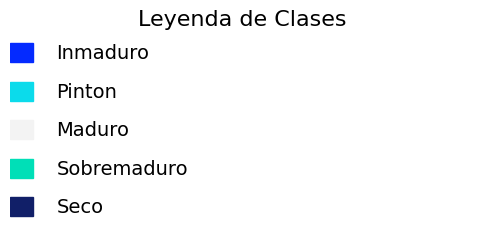


--- 3. Sube una imagen para analizar ---


Saving unnamed - copia.jpg to unnamed - copia.jpg
Imagen 'unnamed - copia.jpg' subida. Guardando temporalmente en Colab...

--- 4. Realizando predicción... ---

image 1/1 /content/unnamed - copia.jpg: 640x288 7 Inmaduros, 8 Pintons, 1 Maduro, 8 Sobremaduros, 4 Secos, 2977.2ms
Speed: 6.5ms preprocess, 2977.2ms inference, 57.7ms postprocess per image at shape (1, 3, 640, 288)

--- 5. Dibujando resultados personalizados... ---


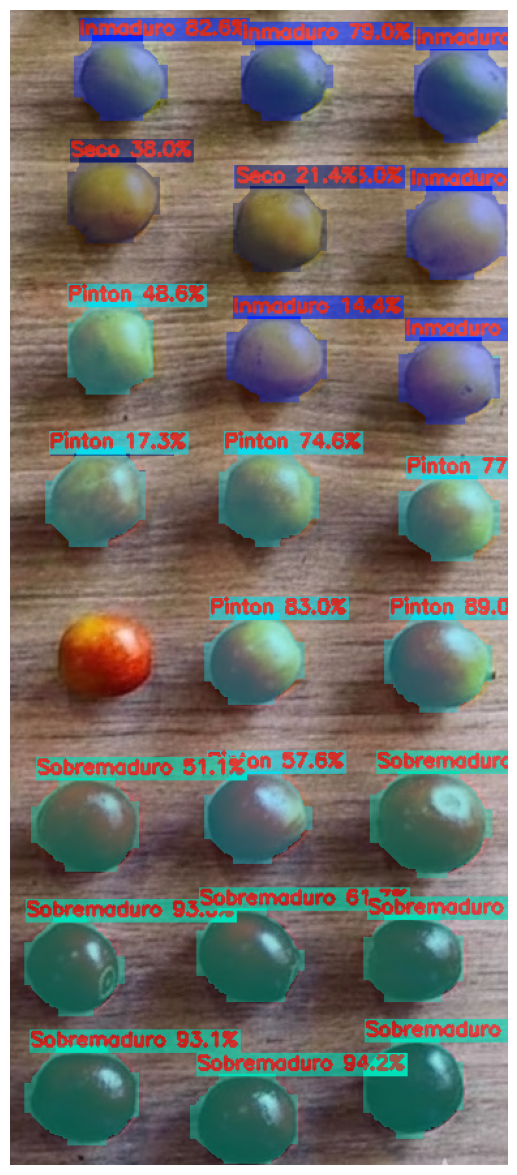

In [ ]:
# --- CELDA 2: Carga del Modelo y Predicción Personalizada (SIN RECTÁNGULOS) ---
import os
from pathlib import Path
import yaml
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from google.colab import files
from ultralytics import YOLO
from ultralytics.utils.plotting import Colors

print("--- [CELDA 2] INICIANDO PRUEBA DE INFERENCIA PERSONALIZADA ---")

# --- 1. Parámetros y Carga del Modelo ---
print("\n--- 1. Cargando tu modelo entrenado desde Google Drive ---")

MODEL_PATH = Path("/content/drive/MyDrive/YOLOv8_Trained_Models/best_F1_yolov8x_img640_b-1.pt")
CONFIDENCE_THRESHOLD = 0.01

try:
    if not MODEL_PATH.exists(): raise FileNotFoundError
    model = YOLO(MODEL_PATH)
    print(f"✅ Modelo cargado exitosamente desde: {MODEL_PATH}")
except FileNotFoundError:
    raise RuntimeError(f"❌ ERROR: No se pudo encontrar el modelo en la ruta especificada: {MODEL_PATH}")
except Exception as e:
    raise RuntimeError(f"❌ Ocurrió un error al cargar el modelo: {e}")

# --- 2. Mostrar Leyenda de Colores ---
print("\n--- 2. Leyenda de Colores de Clase ---")
CLASSES = model.names
colors = Colors()
fig, ax = plt.subplots(1, 1, figsize=(6, len(CLASSES) * 0.5))
ax.axis('off')
for i, name in CLASSES.items():
    color_rgb = tuple(c/255 for c in colors(i, True)[::-1])
    ax.text(0.1, 1 - (i * (1.0 / len(CLASSES)) + 0.1), name, fontsize=14, ha='left', va='center')
    ax.add_patch(plt.Rectangle((0, 1 - (i * (1.0 / len(CLASSES)) + 0.15)), 0.05, 0.1, color=color_rgb))
plt.title("Leyenda de Clases", fontsize=16)
plt.show()

# --- 3. Subir Imagen desde tu Computadora ---
print("\n--- 3. Sube una imagen para analizar ---")
try:
    uploaded = files.upload()
    if not uploaded:
        print("\nNo se seleccionó ningún archivo. Intenta ejecutar la celda de nuevo.")
    else:
        file_name = next(iter(uploaded))

        print(f"Imagen '{file_name}' subida. Guardando temporalmente en Colab...")
        image_path_local = Path(f"/content/{file_name}")
        with open(image_path_local, 'wb') as f:
            f.write(uploaded[file_name])

        # --- 4. Realizar Predicción ---
        print("\n--- 4. Realizando predicción... ---")
        results = model.predict(source=image_path_local, save=False, conf=CONFIDENCE_THRESHOLD)
        result = results[0]

        # --- 5. DIBUJO MANUAL DE RESULTADOS ---
        print("\n--- 5. Dibujando resultados personalizados... ---")
        img = result.orig_img.copy()
        overlay = img.copy()

        if result.masks is not None:
            for i, mask in enumerate(result.masks):
                class_id = int(result.boxes.cls[i])
                confidence = float(result.boxes.conf[i])
                class_name = model.names[class_id]
                color = colors(class_id, True)

                # Dibuja la máscara de segmentación sobre la imagen de superposición
                polygon = mask.xy[0].astype(np.int32)
                cv2.fillPoly(overlay, [polygon], color)

                # Coordenadas para la etiqueta de texto
                bbox = result.boxes.xyxy[i].cpu().numpy().astype(int)
                x1, y1, x2, y2 = bbox

                # Se comenta la línea que dibuja el rectángulo del bounding box.
                # cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                # Dibuja el fondo de la etiqueta y el texto
                label = f"{class_name} {confidence*100:.1f}%"
                (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
                cv2.rectangle(img, (x1, y1 - h - 5), (x1 + w, y1), color, -1)
                # El color del texto es Rojo (en formato BGR)
                cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

        # Combina la imagen original (con las etiquetas) y la superposición de máscaras
        final_image = cv2.addWeighted(overlay, 0.4, img, 0.6, 0)
        # Convierte de BGR a RGB para la visualización correcta en Matplotlib
        final_image_rgb = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)

        # Muestra la imagen final
        plt.figure(figsize=(15, 15))
        plt.imshow(final_image_rgb)
        plt.axis('off')
        # plt.title(f"Resultado de la Segmentación para '{file_name}' (Confianza > {CONFIDENCE_THRESHOLD*100}%)", fontsize=18)
        plt.show()

        # Limpia la imagen subida del entorno de Colab
        os.remove(image_path_local)

except Exception as e:
    import traceback
    print(f"\nOcurrió un error: {e}")
    traceback.print_exc()